In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from scipy.interpolate import interp1d
from classy import Class

%matplotlib inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'axes.labelsize' : 20})
plt.rcParams.update({'axes.grid' : False})

https://github.com/xzackli/Cosmology-Notebooks/blob/master/camb_v_class_2022.ipynb

In [2]:
nuFlag=True
bolt_names = ['h','Omr','Omb','Omcb','ns','Y_p','Neff','smnu','As']
h=0.55
bolt_cosmo = [h,5.042e-5*(0.7/h)**2,0.046*(0.7/h)**2,(0.224+0.046)*(0.7/h)**2,1.0,0.24,3.046,0.1,1e-10*np.exp(3.043)] #this is the choice of Planck TTTEEE in class for nu
cosmo_dict = dict(zip(bolt_names,bolt_cosmo))
# cosmo_dict['Omm'] = cosmo_dict['Omcb']+cosmo_dict['smnu']/93.14/cosmo_dict['h']**2

k = np.logspace(-4,np.log10(20),2000)

In [3]:
cosmo_dict={'h': 0.5222271667627512, 'Omb': 0.0602597963311839, 'Omcb': 0.27467162574577264, 'ns': 0.9280611436133656, 'Y_p': 0.24, 'Neff': 3.046, 'smnu': 0.1729944451915938, 'As': 1.0791952989168323e-09, 'TAGN': 7.2, 'Omcdm': 0.21441182941458875}

In [4]:
class_ref = {
    'recombination': 'RECFAST',
    'tol_ncdm_bg':1.e-10,
    # 'recfast_Nz0':100000,
    'tol_thermo_integration':1.e-5,
    'recfast_x_He0_trigger_delta':0.01,
    'recfast_x_H0_trigger_delta':0.01,
    'evolver':0,
    'k_min_tau0':0.002,
    'k_max_tau0_over_l_max':3.,
    'k_step_sub':0.015,
    'k_step_super':0.0001,
    'k_step_super_reduction':0.1,
    'start_small_k_at_tau_c_over_tau_h':0.0004,
    'start_large_k_at_tau_h_over_tau_k':0.05,
    'tight_coupling_trigger_tau_c_over_tau_h':0.005,
    'tight_coupling_trigger_tau_c_over_tau_k':0.008,
    'start_sources_at_tau_c_over_tau_h':0.006,
    'l_max_g':50,
    'l_max_pol_g':25,
    'l_max_ur':50,
    'l_max_ncdm':50,
    #'tol_perturbations_integration':1.e-6,
    #'perturbations_sampling_stepsize':0.01,
    'l_logstep':1.026,
    'l_linstep':25,
    'hyper_sampling_flat':12.,
    'hyper_sampling_curved_low_nu':10.,
    'hyper_sampling_curved_high_nu':10.,
    'hyper_nu_sampling_step':10.,
    'hyper_phi_min_abs':1.e-10,
    'hyper_x_tol':1.e-4,
    'hyper_flat_approximation_nu':1.e6,
    'q_linstep':0.20,
    'q_logstep_spline':20.,
    'q_logstep_trapzd':0.5,
    'q_numstep_transition':250,
    'transfer_neglect_delta_k_S_t0':100.,
    'transfer_neglect_delta_k_S_t1':100.,
    'transfer_neglect_delta_k_S_t2':100.,
    'transfer_neglect_delta_k_S_e':100.,
    'transfer_neglect_delta_k_V_t1':100.,
    'transfer_neglect_delta_k_V_t2':100.,
    'transfer_neglect_delta_k_V_e':100.,
    'transfer_neglect_delta_k_V_b':100.,
    'transfer_neglect_delta_k_T_t2':100.,
    'transfer_neglect_delta_k_T_e':100.,
    'transfer_neglect_delta_k_T_b':100.,
    'neglect_CMB_sources_below_visibility':1.e-30,
    'transfer_neglect_late_source':3000.,
    'halofit_k_per_decade':3000.,
    'l_switch_limber':40.,
    'accurate_lensing':1,
    'num_mu_minus_lmax':1000.,
    'delta_l_max':1000.,
        'nonlinear_verbose' : 2, 
    'z_infinity':10

}

# additional precision parameters for neutrinos only
class_ref_nu = {
    'radiation_streaming_approximation':2,
    'radiation_streaming_trigger_tau_over_tau_k':240.,
    'radiation_streaming_trigger_tau_c_over_tau':100.,
    'ur_fluid_approximation':2,
    'ur_fluid_trigger_tau_over_tau_k':50.,
    'ncdm_fluid_approximation':3,
    'ncdm_fluid_trigger_tau_over_tau_k':51.,
    'tol_ncdm_synchronous':1.e-10,
    'tol_ncdm_newtonian':1.e-10,
}

In [5]:
def run_camb(cosmo_dict,k,z,nu=False, darkmatter=True, mead='mead2020'):
    camb.camb.set_feedback_level(level=2)
    cosmo_dict['Omcdm'] = cosmo_dict['Omcb']-cosmo_dict['Omb']
    nonlinear = camb.nonlinear.Halofit()
    if darkmatter:
        nonlinear.set_params(halofit_version=mead)#, HMCode_logT_AGN=-20,)
    else:
        nonlinear.set_params(halofit_version=mead+'_feedback',HMCode_logT_AGN=cosmo_dict['TAGN'])#, HMCode_logT_AGN=-20,)
    pars = camb.CAMBparams(NonLinearModel =nonlinear)
    pars.set_cosmology(H0=cosmo_dict['h']*100,
                       ombh2=cosmo_dict['Omb']*cosmo_dict['h']**2,
                       omch2=cosmo_dict['Omcdm']*cosmo_dict['h']**2,
                       mnu=cosmo_dict['smnu'] if nuFlag else 0., 
                       num_massive_neutrinos=1 if nuFlag else 0,

                       YHe=cosmo_dict['Y_p'],
                       omk=0, tau=0.06) #fixed parameters, Planck neutrinos
    pars.set_accuracy(AccuracyBoost=3.0, lAccuracyBoost=3.0, DoLateRadTruncation=False)
    pars.InitPower.set_params(ns=cosmo_dict['ns'],
                              As=cosmo_dict['As'])

    pars.set_matter_power(redshifts=[z],kmax=50/cosmo_dict['h'])#, kmax=kmax/h) 
    pars.share_delta_neff = True 

    results = camb.get_results(pars)
    zmin,zmax = z,z
    nz=1
    camb_interp = camb.get_matter_power_interpolator(pars,zmin=zmin,zmax=zmax,nz_step=nz,nonlinear=False,kmax=50/cosmo_dict['h'])
    pinterp = camb_interp.P #defaults #takes (z,k) pairs
    camb_interp = camb.get_matter_power_interpolator(pars,zmin=zmin,zmax=zmax,nz_step=nz,nonlinear=True,kmax=50/cosmo_dict['h'])
    pinterp_nonlinear = camb_interp.P #defaults #takes (z,k) pairs

    return pinterp(z,k), pinterp_nonlinear(z,k), results


In [6]:
#should really just make a private toolbox with these functions somewhere...
import copy
def run_class(cosmo_dict_in,k,z,nu=False,pk=False,gauge='synchronous',darkmatter=True, mead="HMcode2020"):
    cosmo_dict=copy.deepcopy(cosmo_dict_in)
    '''Simple call to boltzmann code using input cosmology parameter vector. k in h/Mpc.'''
    #setup
    if('h' not in cosmo_dict.keys()):
        h = cosmo_dict['H0']/100.
    elif('H0' not in cosmo_dict.keys()):
        cosmo_dict['H0'] = cosmo_dict['h']*100.
        h = cosmo_dict['h']
    if('Omcdm' not in cosmo_dict.keys()):
        cosmo_dict['Omcdm'] = cosmo_dict['Omcb']-cosmo_dict['Omb']
        # cosmo_dict['Omcdm'] = cosmo_dict['Omm']-cosmo_dict['Omb']
    c,G = 2.99792e5,4.30071e-9 
    cosmo_dict['non linear']=mead
    if darkmatter:
        None
    else:
        cosmo_dict['hmcode2020log10tagn']=7.8


    h=cosmo_dict['h']
    if(nu): 
        #use Planck single massive neutrino if using neutrinos
        N_ncdm=1
        m_ncdm=cosmo_dict['smnu']
    else:
        N_ncdm=0
        m_ncdm=0 
    
    N_ur=3.046-N_ncdm
    # N_ur = 3.046
    print("Nur: {0:.3f}, Nncdm: {1:.3f}, mncdm: {2:.3f}".format(N_ur,N_ncdm,m_ncdm))
    
    ceng = Class()
    #gross but don't want to look up how to do it right now
    if(nuFlag): 
        ceng.set({'h':h,
              'omega_b':cosmo_dict['Omb']*h**2,
              'omega_cdm':cosmo_dict['Omcdm']*h**2,
              #'omega_r':cosmo_dict['Omr']*h**2,
              'n_s':cosmo_dict['ns'],
              'A_s':cosmo_dict['As'],
              'gauge':gauge,
              'N_ur': 2.0308,
              'N_ncdm': N_ncdm,
              'T_ncdm': 0.7133,  # IMPORTANT, see page 11 of arxiv:1104.2935
              'm_ncdm': m_ncdm,
              'YHe': cosmo_dict['Y_p'],
              'ncdm_fluid_approximation':3,
              'z_reio': 7.6711,
            'non linear':cosmo_dict['non linear'],
                  #'z_pk': z,
            'z_max_pk':2
              })
        if not darkmatter:
            ceng.set({'hmcode2020log10tagn':cosmo_dict['hmcode2020log10tagn']})
    else: 
        ceng.set({'h':h,
              'omega_b':cosmo_dict['Omb']*h**2,
              'omega_cdm':cosmo_dict['Omcdm']*h**2,
              #'omega_r':cosmo_dict['Omr']*h**2,
              'n_s':cosmo_dict['ns'],
              'A_s':cosmo_dict['As'],
              'gauge':gauge,
              'N_ur': N_ur,
#               'N_ncdm': N_ncdm,
#               'm_ncdm': m_ncdm,
              'YHe': cosmo_dict['Y_p'],
              'ncdm_fluid_approximation':3,
              'z_reio': 7.6711,    
                    'non linear':cosmo_dict['non linear'],
                #  'z_pk': z+0.1,
              })
        if not darkmatter:
            ceng.set({'hmcode2020log10tagn':cosmo_dict['hmcode2020log10tagn']})
    print(m_ncdm)
    print(ceng.pars)
    #need lower z_max ow issues long complaint, need z<z_rec for pk to work apparently
    ceng.set(class_ref)
    ceng.set(class_ref_nu)
    ceng.set({'output':  'mPk','P_k_max_1/Mpc':50.0})
    ceng.compute()
    plin=[]
    for ki in k: plin.append(ceng.pk_lin(ki*h,z)*h**3) 
    pnl=[]
    for ki in k: pnl.append(ceng.pk(ki*h,z)*h**3) 
    # get P(k) at redshift z=0
    transfers = ceng.get_transfer(z)

    return transfers,plin,pnl,ceng

In [7]:
z=1.008916e+00

In [ ]:
%timeit run_class(cosmo_dict,k,z,nu=nuFlag,pk=True,gauge='synchronous')

Nur: 2.046, Nncdm: 1.000, mncdm: 0.144
0.14387193297114265
{'h': 0.5584692976770793, 'omega_b': 0.016477979494663234, 'omega_cdm': 0.06652937246543816, 'n_s': 0.9824664190456341, 'A_s': 1.0216559726686633e-09, 'gauge': 'synchronous', 'N_ur': 2.0308, 'N_ncdm': 1, 'T_ncdm': 0.7133, 'm_ncdm': 0.14387193297114265, 'YHe': 0.24, 'ncdm_fluid_approximation': 3, 'z_reio': 7.6711, 'non linear': 'HMcode2020', 'z_max_pk': 2}
Nur: 2.046, Nncdm: 1.000, mncdm: 0.144
0.14387193297114265
{'h': 0.5584692976770793, 'omega_b': 0.016477979494663234, 'omega_cdm': 0.06652937246543816, 'n_s': 0.9824664190456341, 'A_s': 1.0216559726686633e-09, 'gauge': 'synchronous', 'N_ur': 2.0308, 'N_ncdm': 1, 'T_ncdm': 0.7133, 'm_ncdm': 0.14387193297114265, 'YHe': 0.24, 'ncdm_fluid_approximation': 3, 'z_reio': 7.6711, 'non linear': 'HMcode2020', 'z_max_pk': 2}
Nur: 2.046, Nncdm: 1.000, mncdm: 0.144
0.14387193297114265
{'h': 0.5584692976770793, 'omega_b': 0.016477979494663234, 'omega_cdm': 0.06652937246543816, 'n_s': 0.98246

In [ ]:
%timeit run_class(cosmo_dict,k,z,nu=nuFlag,pk=True,gauge='synchronous',darkmatter=False)

In [ ]:
%timeit run_class(cosmo_dict,k,z,nu=nuFlag,pk=True,gauge='synchronous', mead="HMcode")

In [25]:
nuFlag

True

In [23]:
# bolt_cosmo = [0.7,5.042e-5,0.046,0.224+0.046,1.0,0.24,3.046,1e-10*np.exp(3.043)] #this is the choice of Planck TTTEEE in class for nu
ts0,pL0,pNL0,ceng = run_class(cosmo_dict,k,z,nu=nuFlag,pk=True,gauge='synchronous')

Nur: 2.046, Nncdm: 1.000, mncdm: 0.173
0.1729944451915938
{'h': 0.5222271667627512, 'omega_b': 0.01643412479305961, 'omega_cdm': 0.05847465435066685, 'n_s': 0.9280611436133656, 'A_s': 1.0791952989168323e-09, 'gauge': 'synchronous', 'N_ur': 2.0308, 'N_ncdm': 1, 'T_ncdm': 0.7133, 'm_ncdm': 0.1729944451915938, 'YHe': 0.24, 'ncdm_fluid_approximation': 3, 'z_reio': 7.6711, 'non linear': 'HMcode2020', 'z_max_pk': 2}


In [24]:
ceng.sigma8()

0.33987886242661075

In [9]:
# bolt_cosmo = [0.7,5.042e-5,0.046,0.224+0.046,1.0,0.24,3.046,1e-10*np.exp(3.043)] #this is the choice of Planck TTTEEE in class for nu
ts0,pL0,pNL0_HMcode2016,ceng = run_class(cosmo_dict,k,z,nu=nuFlag,pk=True,gauge='synchronous', mead="HMcode")

Nur: 2.046, Nncdm: 1.000, mncdm: 0.144
0.14387193297114265
{'h': 0.5584692976770793, 'omega_b': 0.016477979494663234, 'omega_cdm': 0.06652937246543816, 'n_s': 0.9824664190456341, 'A_s': 1.0216559726686633e-09, 'gauge': 'synchronous', 'N_ur': 2.0308, 'N_ncdm': 1, 'T_ncdm': 0.7133, 'm_ncdm': 0.14387193297114265, 'YHe': 0.24, 'ncdm_fluid_approximation': 3, 'z_reio': 7.6711, 'non linear': 'HMcode', 'z_pk': 1}


In [10]:
ts0,pL0,pNL_hy0,ceng = run_class(cosmo_dict,k,z,nu=nuFlag,pk=True,gauge='synchronous',darkmatter=False)

Nur: 2.046, Nncdm: 1.000, mncdm: 0.144
0.14387193297114265
{'h': 0.5584692976770793, 'omega_b': 0.016477979494663234, 'omega_cdm': 0.06652937246543816, 'n_s': 0.9824664190456341, 'A_s': 1.0216559726686633e-09, 'gauge': 'synchronous', 'N_ur': 2.0308, 'N_ncdm': 1, 'T_ncdm': 0.7133, 'm_ncdm': 0.14387193297114265, 'YHe': 0.24, 'ncdm_fluid_approximation': 3, 'z_reio': 7.6711, 'non linear': 'HMcode2020', 'z_pk': 1, 'hmcode2020log10tagn': 7.8}


-> Parameters at redshift z = 0.000000e+00:
 ==================================
    Parameters at redshift z = 1.008916e+00:
    fnu:                1.805822e-02
    sigd [Mpc/h]:       1.974188e+00
    sigd100 [Mpc/h]:    9.949791e-01
    sigma8:             2.378447e-01
    sigma8 cc:          2.378447e-01
    nu min:             8.755116e-01
    nu max:             1.099371e+02
    r_v min [Mpc/h]:    2.520156e-04
    r_v max [Mpc/h]:    2.520156e+01
    r_nl [Mpc/h]:       3.290248e-02
    k_nl [h/Mpc]:       3.039285e+01
    sigma_nl:           9.999996e-01
    neff:               -2.619297e+00
    c min:              5.196000e+00
    c max:              6.057967e+00
    Dv:                 2.019308e+02
    dc:                 1.682642e+00
    g:                  4.716504e-01
    G:                  4.908571e-01
    eta:                2.161861e-01
    k*:                 2.406559e-01
    Abary:              5.196000e+00
    sigma_disp:         1.974188e+00
    alpha:              5.447781e-01
    kd (h/Mpc):            2.722796e-01
    2halo f:            6.986323e-02
    ksize, kmin, kmax:   149, 1.984343e-07, 9.959319e+01

In [37]:
pCAMB, pCAMB_NL, camb_results = run_camb(cosmo_dict,k,z,nu=nuFlag, darkmatter=True)
#pCAMB, pCAMB_NL_Hy, camb_results = run_camb(cosmo_dict,k,z,nu=nuFlag, darkmatter=False)

In [30]:
pCAMB, pCAMB_NL_Hy, camb_results = run_camb(cosmo_dict,k,z,nu=nuFlag, darkmatter=False)

WRITE_PARAMETERS: at this redshift
 ==================================
        z:   0.00000
       Dv: 493.00146
       dc:   1.66737
      eta:   0.13674
       k*:   0.06736
        A:   5.19600
    fdamp:   0.22779
    alpha:   0.69330
    GROWTH: Solving growth equation
     GROWTH: ODE done
     GROWTH: Unnormalised g(a=1):  0.636393249034882
     GROWTH: Accumulated G(a=1):  0.864072216027356
     GROWTH: Done

     LINEAR POWER: Filling linear power HM_tables
     LINEAR POWER: k_min:  1.000000000000000E-003
     LINEAR POWER: k_max:   100.000000000000
     LINEAR POWER: nk:         512
     LINEAR POWER: z of input:  0.000000000000000E+000
     LINEAR POWER: Delta2_min:  6.003104760469995E-007
     LINEAR POWER: Delta2_max:   18.3881964281764
     LINEAR POWER: sigma_8:  0.835929213772295
     LINEAR POWER: Done

     SIGTAB: Filling sigma interpolation table
     SIGTAB: R_min:  9.999999747378752E-005
     SIGTAB: R_max:   1000.00000000000
     SIGTAB: Values:          64
     SIGTAB: sigma_min:  2.533793116562932E-003
     SIGTAB: sigma_max:   16.0818172377472
     SIGTAB: Done

     INIT_WIGGLE: Starting
     INIT_WIGGLE: kmin [h/Mpc]:  4.999999888241290E-003
     INIT_WIGGLE: kmax [h/Mpc]:   5.00000000000000
     INIT_WIGGLE: nk:         512
     INIT_WIGGLE: Splitting into wiggle and broad-band
     INIT_WIGGLE: Isolating wiggle
     INIT_WIGGLE: Initialising interpolator
     INIT_WIGGLE: Done
     HALOMOD: Filling look-up HM_tables
     HALOMOD: HM_tables being filled at redshift:  0.000000000000000E+000
     HALOMOD: sigv [Mpc/h]:   7.00395290680539
     HALOMOD: sigv100 [Mpc/h]:   3.60403186675978
     HALOMOD: sig8(z):  0.835929213772295
     HALOMOD: cold sig8(z):  0.835929213772295
     HALOMOD: M_min [log10(Msun/h)]:  0.000000000000000E+000
     HALOMOD: M_max [log10(Msun/h)]:   17.9999999931845
     HALOMOD: m, r, nu, sig, sigf HM_tables filled
     HALOMOD: rv HM_tables filled
     HALOMOD: nu min:  0.113990947250776
     HALOMOD: nu max:   41.9350235664729
     HALOMOD: sig min:  3.976074624562467E-002
     HALOMOD: sig max:   14.6271951505295
     HALOMOD: R_v min [Mpc/h]:  2.362725886259391E-005
     HALOMOD: R_v max [Mpc/h]:   23.6272684671526
     HALOMOD: r_nl [Mpc/h]:   2.14590683514100
     HALOMOD: k_nl [h/Mpc]:  0.466003455333741
     HALOMOD: n_eff:  -2.10839791857899
     HALOMOD: c HM_tables filled
     HALOMOD: c min [Msun/h]:   5.20552106893297
     HALOMOD: c max [Msun/h]:   90.5349065194655
     HALOMOD: Done

In [19]:
pCAMB, pCAMB_NL_hmcode2016, camb_results = run_camb(cosmo_dict,k,z,nu=nuFlag, darkmatter=True, mead="mead2016")


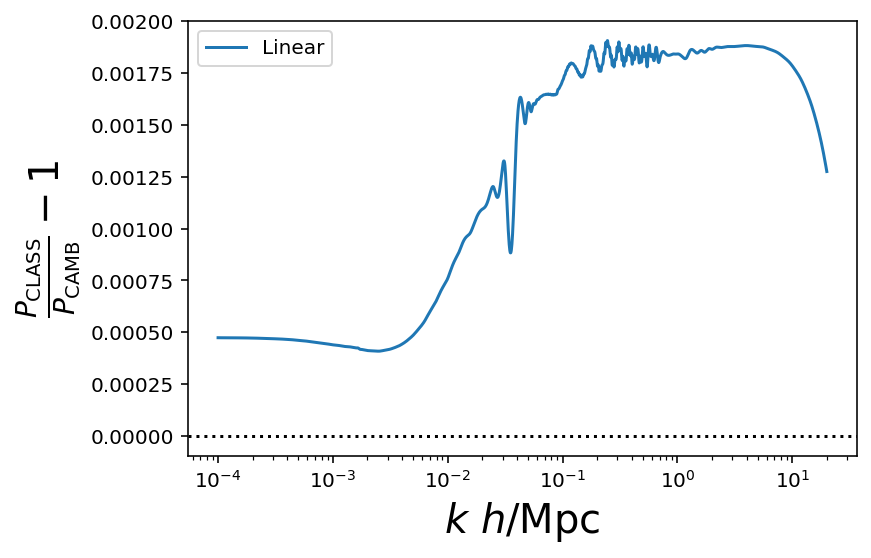

In [38]:
#newtonian vs synch gauge
plt.plot(k,pL0/pCAMB - 1, label="Linear")
plt.xscale('log')
plt.ylabel(r'$\frac{P_{\rm{CLASS}}}{P_{\rm{CAMB}}} - 1$',fontsize=20)
plt.xlabel(r'$k \ h/\rm{Mpc} $',fontsize=20)
plt.axhline(0,ls=':',c='k')
plt.legend()

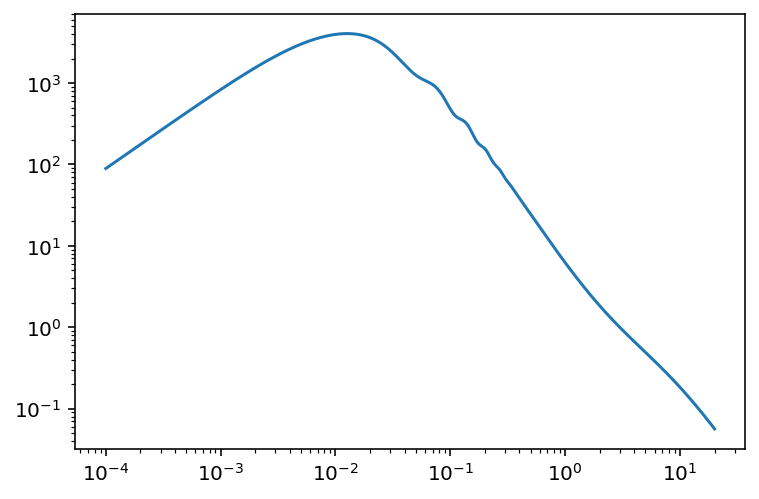

In [21]:
plt.loglog(k, pNL0)

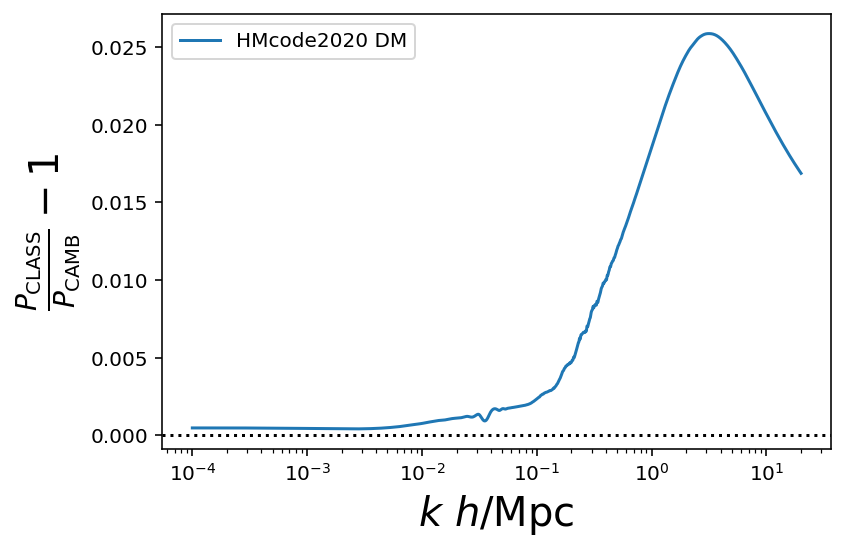

In [39]:
#newtonian vs synch gauge
plt.plot(k,pNL0/pCAMB_NL - 1, label="HMcode2020 DM")
plt.xscale('log')
plt.ylabel(r'$\frac{P_{\rm{CLASS}}}{P_{\rm{CAMB}}} - 1$',fontsize=20)
plt.xlabel(r'$k \ h/\rm{Mpc} $',fontsize=20)
plt.axhline(0,ls=':',c='k')
plt.legend()
### newtonian vs synch gauge
#plt.plot(k,pNL_hy0/pCAMB_NL_Hy - 1, label="HMcode2020 TAGN")
#plt.xscale('log')
#plt.ylabel(r'$\frac{P_{\rm{CLASS}}}{P_{\rm{CAMB}}} - 1$',fontsize=20)
#plt.xlabel(r'$k \ h/\rm{Mpc} $',fontsize=20)
#plt.axhline(0,ls=':',c='k')
#plt.legend()
##newtonian vs synch gauge
#plt.plot(k,pL0/pCAMB - 1, label="Linear")
#plt.xscale('log')
#plt.ylabel(r'$\frac{P_{\rm{CLASS}}}{P_{\rm{CAMB}}} - 1$',fontsize=20)
#plt.xlabel(r'$k \ h/\rm{Mpc} $',fontsize=20)
#plt.axhline(0,ls=':',c='k')
#plt.legend()
#
#plt.plot(k,pNL0_HMcode2016/pCAMB_NL_hmcode2016 - 1, label="HMcode2016")
#plt.xscale('log')
#plt.ylabel(r'$\frac{P_{\rm{CLASS}}}{P_{\rm{CAMB}}} - 1$',fontsize=20)
#plt.xlabel(r'$k \ h/\rm{Mpc} $',fontsize=20)
#plt.axhline(0,ls=':',c='k')
#plt.legend()

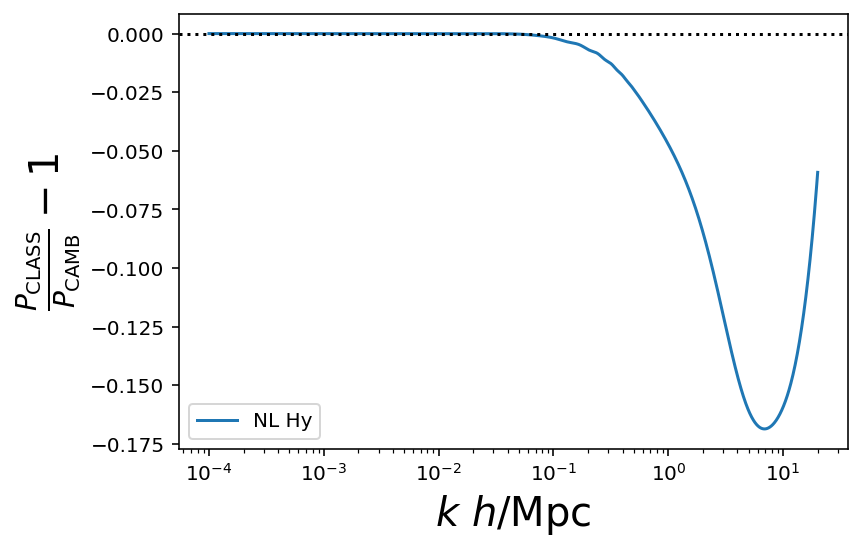

In [13]:
## newtonian vs synch gauge
plt.plot(k,np.array(pNL_hy0)/np.array(pNL0) - 1, label="NL Hy")
plt.xscale('log')
plt.ylabel(r'$\frac{P_{\rm{CLASS}}}{P_{\rm{CAMB}}} - 1$',fontsize=20)
plt.xlabel(r'$k \ h/\rm{Mpc} $',fontsize=20)
plt.axhline(0,ls=':',c='k')
plt.legend()